<a href="https://colab.research.google.com/github/Massshhhina/ML/blob/main/MariaK_TFLite_Week1_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Обучите свою собственную модель и конвертируйте ее в TFLite

Этот ноутбук использует набор данных [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) который содержит 70,000 черно-белых изображений, разбитых на 10 категорий. Изображения представляют отдельные предметы одежды в низком разрешении (28 на 28 пикселей), как показано здесь:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST предназначен для замены классического набора данных [MNIST](http://yann.lecun.com/exdb/mnist/), который часто используется в качестве «Hello, World» программ машинного обучения для компьютерного зрения. Набор данных MNIST содержит изображения рукописных цифр (0, 1, 2 и т. Д.) В формате, идентичном формату предметов одежды, которые мы здесь будем использовать.

Здесь используется Fashion MNIST для разнообразия и потому, что это немного более сложная задача, чем обычный MNIST. Оба набора данных относительно малы и используются для проверки правильности работы алгоритма. Они являются хорошей отправной точкой для тестирования и отладки кода.

Мы  использовуем 60 000 изображений для обучения сети и 10 000 изображений, чтобы оценить, насколько точно сеть научилась классифицировать изображения. Вы можете получить доступ к Fashion MNIST прямо из TensorFlow. Импортируйте и загрузите данные Fashion MNIST прямо из TensorFlow:

# Setup

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


print('\u2022 Используется TensorFlow версии ', tf.__version__)
print('\u2022 Обнаружен GPU.' if tf.test.is_gpu_available() else '\u2022 GPU не обнаружен. Запущено на CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


• Используется TensorFlow версии  2.15.0
• Обнаружен GPU.


#Загрузка набра данных Fashion MNIST

Мы используем TensorFlow Datasets для загрузки набора данных Fashion MNIST.

In [4]:
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=['train[0%:90%]','train[90%:100%]','test'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Имена классов не включены в набор данных, поэтому мы укажем их здесь.

In [5]:
class_names = ['Футболка/топ', 'Брюки', 'Пуловер', 'Платье', 'Пальто',
               'Сандалия', 'Рубашка', 'Кроссовка', 'Сумка', 'Ботинок']

In [6]:
# Создаем файл labels.txt с названиями классов
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [7]:
# Изображения в наборе данных -  28 х 28 пикселей.
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [8]:
# УПРАЖНЕНИЕ: напишите функцию для нормализации изображений.

def format_example(image, label):
    # Преобразуйте изображение к float32
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Нормализуйте изображение к интервалу [0, 1]
    image = image / 255.0

    return image, label

In [9]:
# Определим размер пакета
BATCH_SIZE = 256

## Create Datasets From Images and Labels

In [10]:
# Создание наборов данных тренировки, валидации и тестирования
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.batch(1).map(format_example)

# Построение модели

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
```

In [11]:
# УПРАЖНЕНИЕ: постройте и скомпилируйте модель, как показано в предыдущей ячейке.

model = tf.keras.Sequential([
    # укажите форму ввода (28, 28, 1), размер ядра = 3, фильтры = 16 и используйте активацию ReLU,
    tf.keras.layers.Conv2D(16,(3,3), activation='relu', input_shape=(28,28,1)),

    tf.keras.layers.MaxPooling2D(),

    # Укажите количество фильтров 32, размер ядра  3 и функцию активации ReLU
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),

    # Расплющивание выходного слоя в одномерный массив
    tf.keras.layers.Flatten(),

    # Добавьте полносвязанный слой с 64 скрытыми нейронами и активацией ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Добавьте финальную классификацию softmax
    tf.keras.layers.Dense(10, activation='softmax')])

# Установите подходящую функцию потерь и используйте точность в качестве метрики
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train

In [12]:
model.fit(train_batches,
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
211/211 [==============================] - 12s 36ms/step - loss: 0.6148 - accuracy: 0.7890 - val_loss: 0.4415 - val_accuracy: 0.8455
Epoch 2/10
211/211 [==============================] - 3s 12ms/step - loss: 0.3817 - accuracy: 0.8669 - val_loss: 0.3357 - val_accuracy: 0.8795
Epoch 3/10
211/211 [==============================] - 2s 10ms/step - loss: 0.3302 - accuracy: 0.8838 - val_loss: 0.3542 - val_accuracy: 0.8765
Epoch 4/10
211/211 [==============================] - 1s 5ms/step - loss: 0.3012 - accuracy: 0.8932 - val_loss: 0.2928 - val_accuracy: 0.8977
Epoch 5/10
211/211 [==============================] - 1s 5ms/step - loss: 0.2780 - accuracy: 0.9015 - val_loss: 0.2732 - val_accuracy: 0.9013
Epoch 6/10
211/211 [==============================] - 1s 5ms/step - loss: 0.2590 - accuracy: 0.9065 - val_loss: 0.2621 - val_accuracy: 0.9083
Epoch 7/10
211/211 [==============================] - 1s 5ms/step - loss: 0.2477 - accuracy: 0.9109 - val_loss: 0.2481 - val_accuracy: 0.9118
Ep

# Экспорт в TFLite

Теперь вы сохраните модель в TFLite. Следует отметить, что вы, вероятно, увидите некоторые предупреждающие сообщения при запуске кода ниже. Эти предупреждения связаны с обновлениями программного обеспечения и не должны вызывать ошибок или препятствовать запуску вашего кода.

In [13]:
# УПРАЖНЕНИЕ: используйте API tf.saved_model, чтобы сохранить модель в формате SavedModel.
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

In [ ]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [14]:
# УПРАЖНЕНИЕ: используйте TFLiteConverter SavedModel API для инициализации конвертера

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Установите оптимизацию
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Вызовите конвертер, чтобы окончательно сгенерировать модель TFLite
tflite_model = converter.convert()

In [15]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

259728

# Тестирование модели с интерпретатором TFLite

In [16]:
# Загружаем модель TFLite и выделяем тензоры.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [17]:
# Собираем результаты для случайно выбранных тестовых изображений
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

In [18]:
#@title Служебные функции для построения графиков
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

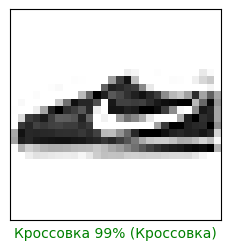

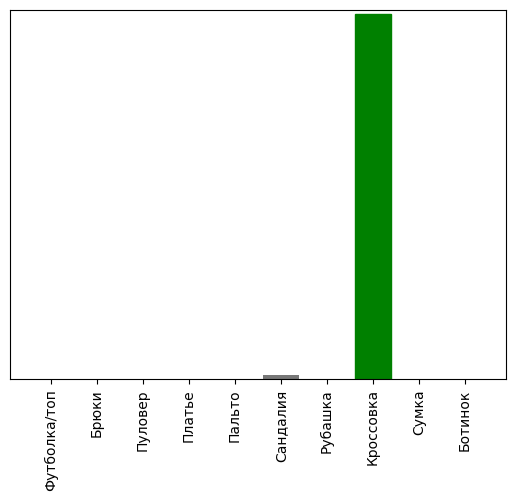

In [20]:
#@title Визуализация результатов { run: "auto" }
index = 16 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Загрузите модель и ресурсы TFLite

вы можете запустить ячейку ниже, чтобы загрузить модель tflite и этикетки на свой локальный диск.

**Примечание**: если файлы не загружаются при запуске ячейки, попробуйте запустить ячейку второй раз. Ваш браузер может предложить вам разрешить загрузку нескольких файлов.

In [21]:
try:
    from google.colab import files

    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Подготовка тестовых изображений для загрузки (необязательно)

In [22]:
!mkdir -p test_images

In [23]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

FileNotFoundError: ignored

In [ ]:
!ls test_images

In [ ]:
!zip -qq fmnist_test_images.zip -r test_images/

Вы можете запустить ячейку ниже, чтобы загрузить Zip-файл с изображениями на свой локальный диск.

**Примечание**: если Zip-файл не загружается при запуске ячейки, попробуйте запустить ячейку второй раз.

In [ ]:
try:
    files.download('fmnist_test_images.zip')
except:
    pass